Attempt to reproduce Figure 2.2 for http://www.incompleteideas.net/book/bookdraft2017nov5.pdf. It shows how the value of ε affects the performance of ε-greedy algorithm

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 6)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# for reproducibility
np.random.seed(10)

# Sample $q^*(a)$, i.e. generate the ground truth

In [3]:
class BanditEnv(object):
    def __init__(self, num_arms=10, mean=0, stdev=1):
        self.num_arms = num_arms
        self.actions = np.arange(num_arms)
        
        # q* for each arm
        self.q_star = np.random.normal(loc=mean, scale=stdev, size=num_arms)
        self.optimal_action = np.argmax(self.q_star)
        
        # potential feature, different variance for each arm
        self.stdev = stdev
            
    def reward(self, action):
        return np.random.normal(self.q_star[action], scale=self.stdev)

In [4]:
bandit = BanditEnv()

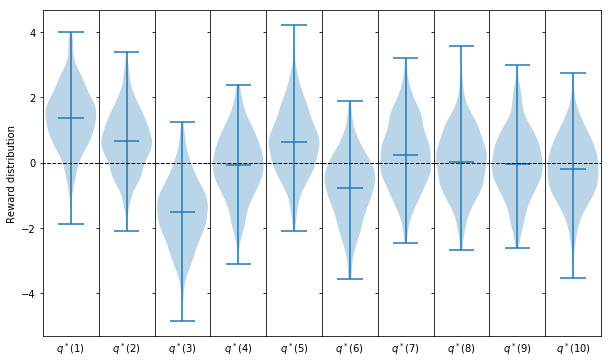

In [5]:
fig, axes = plt.subplots(1, 10, sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0})
axes = axes.ravel()

for k, q_m in enumerate(bandit.q_star):
    ax = axes[k]
    # plot the distribution very close to the real one by sampling a big number of data
    ax.violinplot(np.random.normal(q_m, scale=bandit.stdev, size=500),  showmeans=True)
    ax.set_xticks([])
    ax.set_xlabel('$q^*({0})$'.format(k + 1))
    xlim = ax.get_xlim()
    ax.plot([0, 2], [0, 0], '--', lw=1, color='black')
    ax.set_xlim(xlim)
    if k == 0:
        ax.set_ylabel('Reward distribution')

#### Estimate initial $q$ for each arm with a few (possibly one) round of comprehensive arm pulling

In [6]:
class Agent(object):
    def __init__(self, env, epsilon=0):
        self.env = env
        self.q = np.repeat(0., env.actions.shape[0]) # estimated q

        # with the following two, estimated q can be updated
        
        # total q collected for each arm
        self.total_q = np.repeat(0., env.actions.shape[0])
        # counts of the number of visits to each arm
        self.pull_count = np.repeat(0, env.actions.shape[0])
        
        self.epsilon = epsilon
        self.reward_history = []
        self.action_history = []
    
    def update_q(self):
        self.q = self.total_q / self.pull_count
    
    def init_q(self, rounds=1):
        """Initialize q by pulling each arm a few times"""
        for _ in range(rounds):
            for action in self.env.actions:
                rew = self.env.reward(action)
                self.total_q[action] += rew
                self.pull_count[action] += 1
        self.update_q()
        
    def pi(self):
        # return an action based on defined policy, when epsilon == 0, it's a greedy policy
        if np.random.random() >= self.epsilon:
            return np.argmax(self.q)
        else:
            return np.random.choice(self.env.actions)
        
    def step(self, action=None):
        if action is None:
            action = self.pi()
        rew = self.env.reward(action)
        self.total_q[action] += rew
        self.pull_count[action] += 1
        self.q[action] = self.total_q[action] / self.pull_count[action]
        
        self.reward_history.append(rew)
        self.action_history.append(action)
        
    def compute_value_history(self):
        """calculate value_history based on reward_history, undiscounted"""
        return np.cumsum(self.reward_history) / (np.arange(len(self.reward_history)) + 1)
    
    def compute_frac_optim_action_history(self):
        optimal_action = np.argmax(self.env.q_star)
        act_hist = np.array(self.action_history)
        frac_hist = []
        for i in np.arange(act_hist.shape[0]) + 1:
            sub_hist = act_hist[:i]
            mask = sub_hist == optimal_action
            frac = sub_hist[mask].shape[0] / i
            frac_hist.append(frac)
        return frac_hist

# Comparing policies with different $\epsilon$

In [7]:
num_repeats = 100
num_steps = 5000

ave_rewards_dd = {}
frac_optimal_actions_dd = {}

# std_rewards_dd = {}

epsilons = [0, 0.01, 0.04, 0.1]
for eps in epsilons:
    val_hist_list = [] # records value history of all steps
    frac_hist_list = []
    for _ in range(num_repeats):
        ag = Agent(env=bandit, epsilon=eps)
        ag.init_q()
        for i in range(num_steps):
            ag.step()
        val_hist_list.append(ag.compute_value_history())
        frac_hist_list.append(ag.compute_frac_optim_action_history())
        
    val_hist_arr = np.array(val_hist_list)
    ave_rewards_dd[eps] = val_hist_arr.mean(axis=0)
    
    frac_hist_arr = np.array(frac_hist_list)
    frac_optimal_actions_dd[eps] = frac_hist_arr.mean(axis=0)
#     std_rewards_dd[eps] = val_hist_arr.std(axis=0)

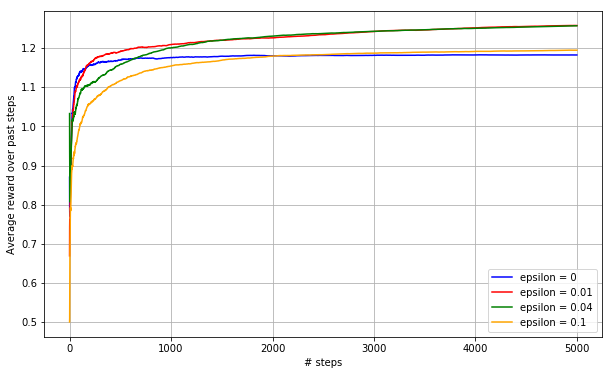

In [8]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'green', 'orange']
for k, eps in enumerate(epsilons):
    col = colors[k]
    steps = np.arange(len(ave_rewards_dd[eps]))
    plt.plot(steps, ave_rewards_dd[eps], color=col, lw=1.5, label='epsilon = {0}'.format(eps))
#     plt.fill_between(steps, ave_rewards_dd[eps] - std_rewards_dd[eps],  ave_rewards_dd[eps] + std_rewards_dd[eps],
#                      color=col, alpha=0.1, lw=1.5, label='epsilon = {0}'.format(eps))
plt.legend(loc='best')
plt.grid()
plt.xlabel('# steps')
plt.ylabel('Average reward over past steps')

Zoom in

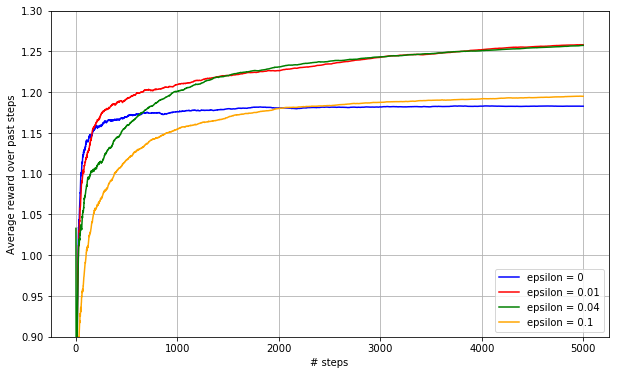

In [12]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'green', 'orange']
for k, eps in enumerate(epsilons):
    col = colors[k]
    steps = np.arange(len(ave_rewards_dd[eps]))
    plt.plot(steps, ave_rewards_dd[eps], color=col, lw=1.5, label='epsilon = {0}'.format(eps))
plt.grid()
plt.ylim(0.9, 1.3)
plt.xlabel('# steps')
plt.ylabel('Average reward over past steps')
plt.legend(loc='lower right')

My experience is that 

* Depends on the scale of the reward function, there could be a decent chance that the agent finds the best arm to pull within the first round of initialization.
* Make sure there are enough steps, otherwise you may not see the transition
* $\epsilon = 0.1$ is likely to be too much exploration.

Plot fraction of optimal actions

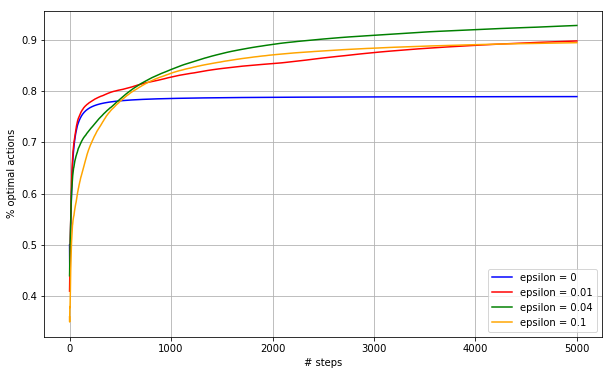

In [10]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'green', 'orange']
for k, eps in enumerate(epsilons):
    col = colors[k]
    steps = np.arange(len(frac_optimal_actions_dd[eps]))
    plt.plot(steps, frac_optimal_actions_dd[eps], color=col, lw=1.5, label='epsilon = {0}'.format(eps))
plt.grid()
# plt.ylim(0.6, 1)
plt.xlabel('# steps')
plt.ylabel('% optimal actions')
plt.legend(loc='lower right')